In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import ElementFraction

In [2]:
df  = pd.read_pickle('../deliver/NIST_CeramicDataSet.pkl')

In [30]:
df.loc[3892, 'Flexural Strength']

nan

In [3]:
# df1 = df.copy()
# df1.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

In [4]:
# # Parse the chemicalFormula
# def formula_decompose(formula):
#     '''
#     decompose chemical formula 
#     return
#         composition: list, [(element,num),...]
#             element: string
#             num: string, can be math expression such as '1+0.5x'
#     '''

#     comp = []
#     p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

#     #split the chemical formula if there is dots, but not for cases like Mg1.5x
#     if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
#         formula = formula.split('.')
#         for item in formula:
#             prefactor = '1'
#             for i in re.findall(p, item):
#                 pre, elem, num = i
#                 if pre:
#                     prefactor = pre
#                 if num == '':
#                     num = '1'
#                 num = prefactor + '*({})'.format(num)
#                 comp.append((elem, num))
#     else:
#         prefactor = '1'
#         for i in re.findall(p, formula):
#             pre, elem, num = i
#             if pre:
#                 prefactor = pre
#             if num == '':
#                 num = '1'
#             num = prefactor + '*({})'.format(num)
#             comp.append((elem, num))
#     return comp 

# def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
#     '''
#     reconstruct chemical formula from composition
#     composition in form of [(element,num), (element,num),...]
#         element: string
#         num: string, can be math expression such as '1+0.5x'

#     return 
#         flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
#     '''
#     flat_list = []
#     for (elem, num) in composition:
#         num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
#         flat_list.append(elem)
#         flat_list.append(format(eval(num), '.1f'))
#     return ''.join(flat_list)
  
# def formula_parser(formula):
#     return formula_reconstruct(formula_decompose(formula))

In [5]:
# df1["flatFormula"] = df1["chemicalFormula"].map(formula_parser)
# df1.dropna(axis=1).head()

In [6]:
# df1["composition"] =df1["flatFormula"].transform(str_to_composition)
# df1.dropna(axis=1).head()

## Looking at various properties in the original dataset (e.g. flexural strength)

In [7]:
# New DataFrame containing only samples with a flexural strength value
fs = df[df.isnull()['Flexural Strength'] == False]
fs.shape

(484, 161)

In [8]:
# Check if all units are the same, in which case we don't need the units.
fs['Flexural Strength-units'].unique()

array(['MPa'], dtype=object)

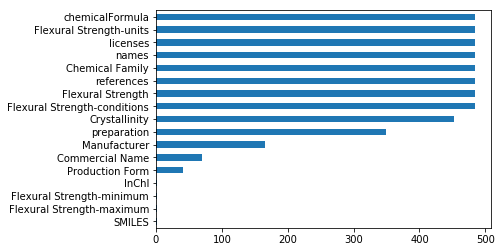

In [9]:
# Plot occurrence of features of the reduced dataset
fs.count().sort_values()[-17:].plot.barh()
plt.show()

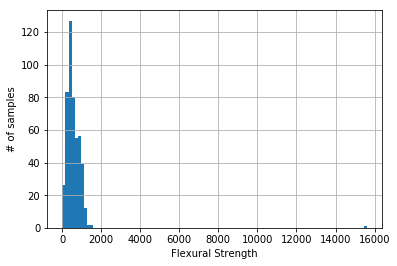

In [10]:
fsn = fs['Flexural Strength'].dropna()
fsn = pd.to_numeric(fsn, errors='coerce')
fsn.hist(bins=100)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

In [11]:
# Drop all columns that contain less than 400 entries 
fs = fs.dropna(axis=1, thresh=400)
fs.head()

,chemicalFormula,licenses,names,references,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions,Flexural Strength-units
10,Si3N4.xY2O3.ySrO,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'citation': 'Ceramic Technology Project Data...,"Si-N:SrO,Y",Polycrystalline,707,"[{'name': 'Temperature', 'scalars': [{'value':...",MPa
34,TiN,[{'name': 'NIST_SRD-30'}],[Titanium nitride],[{'citation': 'The Mechanical Properties of Ho...,Ti-N,Polycrystalline,167,"[{'name': 'Mass Fraction of Additive', 'scalar...",MPa
37,ZrO2.xMgO,[{'name': 'NIST_SRD-30'}],[Zirconia (PSZ)],[{'citation': 'Characterization Studies of Tra...,Zr-O:MgO,NaN,677,"[{'name': 'Temperature', 'scalars': [{'value':...",MPa
41,Al2O3.xZrO2,[{'name': 'NIST_SRD-30'}],[Alumina composite],[{'citation': 'Characterization Studies of Tra...,Al-O:ZrO,NaN,1265,"[{'name': 'Temperature', 'scalars': [{'value':...",MPa
44,ZrO2.xY2O3,[{'name': 'NIST_SRD-30'}],[Zirconia (TZP)],[{'citation': 'Evaluation of Japanese Yttria T...,Zr-O:Y,Polycrystalline,1045,"[{'name': 'Oxidation Temperature', 'scalars': ...",MPa


In [12]:
# Determine number of polycrystalline / single crystal samples
N_polyX = fs[fs['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = fs[fs['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (444,), Single crystal: (8,)


In [13]:
#Fill NaN values in crystallinity with polycrystalline:
fs['Crystallinity'] = fs['Crystallinity'].fillna('Polycrystalline')
N_polyX = fs[fs['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = fs[fs['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (476,), Single crystal: (8,)


In [14]:
# Check how many values cannot simply be transformed from string to int
#also locate which row the errors occur in

N_errors, N_total, row = 0, 0, -1
for entry in fs['Flexural Strength']:
    row+=1
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
        print(row)
        
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))

359 (15%)
295
1 errors in 484 samples


In [15]:
fs.iloc[295]

chemicalFormula                                                               SiC
licenses                                                [{'name': 'NIST_SRD-30'}]
names                                                           [Silicon carbide]
references                      [{'citation': 'Material Properties of a Sinter...
Chemical Family                                                              Si-C
Crystallinity                                                     Polycrystalline
Flexural Strength                                                       359 (15%)
Flexural Strength-conditions    [{'name': 'Temperature', 'scalars': [{'value':...
Flexural Strength-units                                                       MPa
Name: 2451, dtype: object

In [16]:
fs.set_value(2451, 'Flexural Strength', '359');
fs.loc[2451]

chemicalFormula                                                               SiC
licenses                                                [{'name': 'NIST_SRD-30'}]
names                                                           [Silicon carbide]
references                      [{'citation': 'Material Properties of a Sinter...
Chemical Family                                                              Si-C
Crystallinity                                                     Polycrystalline
Flexural Strength                                                             359
Flexural Strength-conditions    [{'name': 'Temperature', 'scalars': [{'value':...
Flexural Strength-units                                                       MPa
Name: 2451, dtype: object

In [17]:
fs['Flexural Strength'] = fs['Flexural Strength'].astype(float)
fs = fs.drop(['licenses','names','references','Flexural Strength-units','Flexural Strength-conditions'], axis=1)
fs.sort_values(by='Flexural Strength')

,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength
2486,C,C,Polycrystalline,20.0
2312,3Al2O3.2SiO2,Al-Si-O,Polycrystalline,46.0
562,ZrO2,Zr-O,Polycrystalline,50.0
1575,Y2O3.xZrO2,Y-O:ZrO,Polycrystalline,63.0
510,MgAl2O4,Mg-Al-O,Polycrystalline,79.0
1090,BeO,Be-O,Polycrystalline,83.0
3526,Al2O3,Al-O,Polycrystalline,88.0
2196,3Al2O3.2SiO2.xZrO2,Al-Si-O:ZrO,Polycrystalline,100.0
3402,C,C,Polycrystalline,105.0
2452,Al2O3,Al-O,Polycrystalline,105.0


In [18]:
N_unique_entries = len(fs['chemicalFormula'].unique())
print('There are just {0} unique entries in the {1} materials.'.format(N_unique_entries,fs.shape[0]))

There are just 115 unique entries in the 484 materials.


In [19]:
fs = fs.reset_index()
fs.head()

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength
0,10,Si3N4.xY2O3.ySrO,"Si-N:SrO,Y",Polycrystalline,707.0
1,34,TiN,Ti-N,Polycrystalline,167.0
2,37,ZrO2.xMgO,Zr-O:MgO,Polycrystalline,677.0
3,41,Al2O3.xZrO2,Al-O:ZrO,Polycrystalline,1265.0
4,44,ZrO2.xY2O3,Zr-O:Y,Polycrystalline,1045.0


In [21]:
fs.sort_values(by='Flexural Strength')

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength
301,2486,C,C,Polycrystalline,20.0
273,2312,3Al2O3.2SiO2,Al-Si-O,Polycrystalline,46.0
68,562,ZrO2,Zr-O,Polycrystalline,50.0
196,1575,Y2O3.xZrO2,Y-O:ZrO,Polycrystalline,63.0
62,510,MgAl2O4,Mg-Al-O,Polycrystalline,79.0
130,1090,BeO,Be-O,Polycrystalline,83.0
408,3526,Al2O3,Al-O,Polycrystalline,88.0
256,2196,3Al2O3.2SiO2.xZrO2,Al-Si-O:ZrO,Polycrystalline,100.0
390,3402,C,C,Polycrystalline,105.0
296,2452,Al2O3,Al-O,Polycrystalline,105.0


In [25]:
#we get rid of the last row because the flexural strength is a huge outlier
fs = fs.drop(fs.index[[427]])
fs.sort_values(by='Flexural Strength')

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength
301,2486,C,C,Polycrystalline,20.0
273,2312,3Al2O3.2SiO2,Al-Si-O,Polycrystalline,46.0
68,562,ZrO2,Zr-O,Polycrystalline,50.0
196,1575,Y2O3.xZrO2,Y-O:ZrO,Polycrystalline,63.0
62,510,MgAl2O4,Mg-Al-O,Polycrystalline,79.0
130,1090,BeO,Be-O,Polycrystalline,83.0
408,3526,Al2O3,Al-O,Polycrystalline,88.0
256,2196,3Al2O3.2SiO2.xZrO2,Al-Si-O:ZrO,Polycrystalline,100.0
390,3402,C,C,Polycrystalline,105.0
296,2452,Al2O3,Al-O,Polycrystalline,105.0


In [26]:
fsg = fs.groupby(['chemicalFormula','Crystallinity'], as_index=False).mean()
fsg.head()

,chemicalFormula,Crystallinity,index,Flexural Strength
0,$\beta$-Si3Al3O3N5,Polycrystalline,175.0,455.000000
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,2575.0,380.000000
2,3Al2O3.2SiO2,Polycrystalline,2156.0,265.615385
3,3Al2O3.2SiO2.xSiC,Polycrystalline,1070.0,366.000000
4,3Al2O3.2SiO2.xZrO2,Polycrystalline,2760.5,200.000000


In [27]:
len(fs['Chemical Family'].unique())

82

In [31]:
fsg1 = fsg.copy()

# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [33]:
fsg1["flatFormula"] = fsg1["chemicalFormula"].map(formula_parser)
fsg1.dropna(axis=1).head()

,chemicalFormula,Crystallinity,index,Flexural Strength,flatFormula
0,$\beta$-Si3Al3O3N5,Polycrystalline,175.0,455.000000,Si3.0Al3.0O3.0N5.0
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,2575.0,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1
2,3Al2O3.2SiO2,Polycrystalline,2156.0,265.615385,Al6.0O9.0Si2.0O4.0
3,3Al2O3.2SiO2.xSiC,Polycrystalline,1070.0,366.000000,Al6.0O9.0Si2.0O4.0Si0.1C0.1
4,3Al2O3.2SiO2.xZrO2,Polycrystalline,2760.5,200.000000,Al6.0O9.0Si2.0O4.0Zr0.1O0.2


In [34]:
fsg1["composition"] =fsg1["flatFormula"].transform(str_to_composition)
fsg1.dropna(axis=1).head()

,chemicalFormula,Crystallinity,index,Flexural Strength,flatFormula,composition
0,$\beta$-Si3Al3O3N5,Polycrystalline,175.0,455.000000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)"
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,2575.0,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)"
2,3Al2O3.2SiO2,Polycrystalline,2156.0,265.615385,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)"
3,3Al2O3.2SiO2.xSiC,Polycrystalline,1070.0,366.000000,Al6.0O9.0Si2.0O4.0Si0.1C0.1,"(Al, O, Si, C)"
4,3Al2O3.2SiO2.xZrO2,Polycrystalline,2760.5,200.000000,Al6.0O9.0Si2.0O4.0Zr0.1O0.2,"(Al, O, Si, Zr)"


In [36]:
print(len(fsg1['composition'].unique()))
print(len(fsg1['chemicalFormula'].unique()))

113
115


In [39]:
#we see some issues with chemical formula and composition since there isn't the same number of unique values
pd.options.display.max_rows = 1000
fsg1

,chemicalFormula,Crystallinity,index,Flexural Strength,flatFormula,composition
0,$\beta$-Si3Al3O3N5,Polycrystalline,175.000000,455.000000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)"
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,2575.000000,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)"
2,3Al2O3.2SiO2,Polycrystalline,2156.000000,265.615385,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)"
3,3Al2O3.2SiO2.xSiC,Polycrystalline,1070.000000,366.000000,Al6.0O9.0Si2.0O4.0Si0.1C0.1,"(Al, O, Si, C)"
4,3Al2O3.2SiO2.xZrO2,Polycrystalline,2760.500000,200.000000,Al6.0O9.0Si2.0O4.0Zr0.1O0.2,"(Al, O, Si, Zr)"
5,3Al2O3.2SiO3.2ZrO2,Polycrystalline,787.000000,400.000000,Al6.0O9.0Si2.0O6.0Zr2.0O4.0,"(Al, O, Si, Zr)"
6,AL2O3,Polycrystalline,1431.000000,200.000000,A1.0L2.0O3.0,"(A0+, L0+, O)"
7,Al2O3,Polycrystalline,2186.629630,395.259259,Al2.0O3.0,"(Al, O)"
8,Al2O3.LaAl11O18.ySiO2,Polycrystalline,2868.000000,631.000000,Al2.0O3.0La1.0Al11.0O18.0Si0.1O0.2,"(Al, O, La, Si)"
9,Al2O3.xCeO2.yZrO2,Polycrystalline,2856.600000,905.400000,Al2.0O3.0Ce0.1O0.2Zr0.1O0.2,"(Al, O, Ce, Zr)"


In [40]:
fs_feat = fsg1.copy() # Create new DataFrame for featurization

In [41]:
# Add features with matminer (using the floating point composition by Chih-Hao)
ep_feat = ElementProperty.from_preset(preset_name="magpie")
fs_feat = ep_feat.featurize_dataframe(fs_feat, col_id="composition", ignore_errors=True)

In [42]:
fs_feat.shape

(118, 138)

In [43]:
# List of the new columns
list(set(fs_feat.columns) ^ set(fs.columns))[:10]

['maximum MendeleevNumber',
 'mode NfValence',
 'mean Number',
 'avg_dev NsValence',
 'mean NfValence',
 'mode NpValence',
 'mode NfUnfilled',
 'mode SpaceGroupNumber',
 'mean Electronegativity',
 'mode NdUnfilled']

In [45]:
# Adds a column for every element. Values are fraction of atoms that belong to that element.
ep_frac = ElementFraction()
fs_feat = ep_frac.featurize_dataframe(fs_feat, col_id = "composition", ignore_errors = True)
fs_feat.head()

ValueError: "H" exists in input dataframe

In [ ]:
# New DataFrame containing only samples with a fracture toughness value
fs = df[df.isnull()['Fracture Toughness'] == False]
fs.shape